# 성능 개선 
feature engineering + Optuna + rolling CV

In [113]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import joblib
import lightgbm as lgb

BASE = Path("..").resolve() / "data_pipeline"

TRAIN_CSV   = BASE / "features_train.csv"
TEST_CSV    = BASE / "features_test.csv"
PRED_CSV    = BASE / "predictions.csv"
MODEL_PATH  = BASE / "lightgbm_model.pkl"
FEATS_JSON  = BASE / "lightgbm_features.json"

print("DATA DIR:", BASE)
print("Files exist?",
      TRAIN_CSV.exists(),
      TEST_CSV.exists(),
      PRED_CSV.exists(),
      MODEL_PATH.exists(),
      FEATS_JSON.exists()
)


DATA DIR: C:\Users\chosw\ORDER101_AI\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline
Files exist? True True True True True


In [114]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [115]:
train = pd.read_csv(TRAIN_CSV, parse_dates=["target_date"])
test  = pd.read_csv(TEST_CSV,  parse_dates=["target_date"])

print("train shape:", train.shape)
print("test shape :", test.shape)
display(train.head(3))

with open(FEATS_JSON, "r", encoding="utf-8") as f:
    features = json.load(f)

print("\n# of features:", len(features))
print(features)

model = joblib.load(MODEL_PATH)
print("\nLoaded model type:", type(model))
print("best_iteration_:", getattr(model, "best_iteration_", None))

pred_df = pd.read_csv(PRED_CSV, parse_dates=["target_date"])
print("\npredictions.csv shape:", pred_df.shape)
display(pred_df.head(3))


train shape: (266500, 48)
test shape : (33800, 48)


,target_date,warehouse_id,store_id,sku_id,region,cat_low,actual_order_qty,lag_1,lag_2,lag_4,...,back_to_school,avg_temp_c_ma4,cdd_ma4,hdd_ma4,precip_mm_ma4,himart_sales_index_ma4,holiday_index_ma4,marketing_score_ma4,y,split
0,2023-02-27,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,NaN,NaN,NaN,...,1.0,3.375,0.0,102.375,0.250,76.0,0.0,0.101620,0.0,train
1,2023-03-06,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,NaN,NaN,...,1.0,5.350,0.0,88.525,2.725,76.0,0.0,0.172892,0.0,train
2,2023-03-13,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,NaN,...,1.0,6.150,0.0,82.825,2.625,76.0,0.0,0.198548,0.0,train



# of features: 37
['lag_1', 'lag_2', 'lag_4', 'lag_8', 'lag_12', 'ma_4', 'ma_8', 'ma_12', 'std_4', 'std_12', 'trend_1', 'trend_4', 'promo_flag_prev', 'year', 'weekofyear', 'month', 'sin_week', 'cos_week', 'avg_temp_c', 'cdd', 'hdd', 'precip_mm', 'heat_wave', 'cold_wave', 'himart_sales_krw', 'himart_sales_index', 'holiday_index', 'marketing_score', 'seasonal_peak', 'back_to_school', 'avg_temp_c_ma4', 'cdd_ma4', 'hdd_ma4', 'precip_mm_ma4', 'himart_sales_index_ma4', 'holiday_index_ma4', 'marketing_score_ma4']

Loaded model type: <class 'lightgbm.sklearn.LGBMRegressor'>
best_iteration_: 3000

predictions.csv shape: (33800, 7)


,warehouse_id,store_id,sku_id,region,target_date,y,y_pred
0,1,1,AC-CAR-16P-2024,본사창고,2031-01-06,2528.0,2518
1,1,1,AC-CAR-16P-2024,본사창고,2031-01-13,3256.0,3229
2,1,1,AC-CAR-16P-2024,본사창고,2031-01-20,3097.0,3062


## 지표 함수 정의 & 전체 성능 재확인

In [116]:
from sklearn.metrics import mean_absolute_error

def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff  = np.abs(y_true - y_pred)
    denom = np.where(denom == 0, 1.0, denom)
    return np.mean(diff / denom) * 100.0

def mape(y_true, y_pred):
    denom = np.where(y_true == 0, 1.0, y_true)
    return (np.abs((y_true - y_pred) / denom)).mean() * 100.0

y_true = pred_df["y"].values
y_pred = pred_df["y_pred"].values

mae   = mean_absolute_error(y_true, y_pred)
mape_ = mape(y_true, y_pred)
smape_= smape(y_true, y_pred)

print(f"TEST MAE = {mae:,.3f}")
print(f"TEST MAPE = {mape_:,.2f}%")
print(f"TEST SMAPE = {smape_:,.2f}%")
print("n =", len(y_true))


TEST MAE = 506.656
TEST MAPE = 23.07%
TEST SMAPE = 4.49%
n = 33800


## Feature Importance (split 기준)

Feature importance (split / 횟수 기준)

In [117]:
# LGBMRegressor는 내부에 booster_를 가지고 있음
booster = model.booster_

imp_split = booster.feature_importance(importance_type="split")
feat_names = booster.feature_name()

imp_split_df = (
    pd.DataFrame({"feature": feat_names, "importance_split": imp_split})
      .sort_values("importance_split", ascending=False)
      .reset_index(drop=True)
)

imp_split_df.head(20)


,feature,importance_split
0,lag_1,12084
1,trend_1,11367
2,trend_4,10737
3,lag_4,9780
4,lag_2,9016
5,std_4,7647
6,ma_4,5424
7,ma_8,4565
8,std_12,3454
9,weekofyear,2749


상위 20개 피처 bar plot (split 기준)

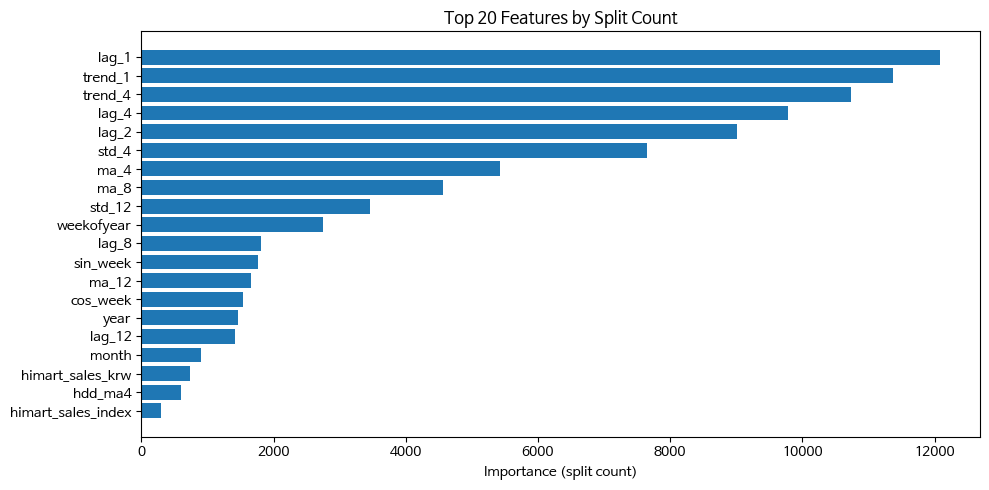

In [118]:
top_n = 20
top_split = imp_split_df.head(top_n)

plt.figure(figsize=(10, 5))
plt.barh(top_split["feature"][::-1], top_split["importance_split"][::-1])
plt.xlabel("Importance (split count)")
plt.title(f"Top {top_n} Features by Split Count")
plt.tight_layout()
plt.show()


Feature Importance (gain 기준)

-> 피처 중요도   
lag_1이 제일 큼 (1주일전 수요) - 가장 큰 영향  
최근 4주 이동평균(ma_4) + 주차/연도(시즌성)도 중요  
날씨/마케팅 변수는 영향을 주지만 메인 영향은 아님  

In [119]:
imp_gain = booster.feature_importance(importance_type="gain")

imp_gain_df = (
    pd.DataFrame({"feature": feat_names, "importance_gain": imp_gain})
      .sort_values("importance_gain", ascending=False)
      .reset_index(drop=True)
)

imp_gain_df.head(20)


,feature,importance_gain
0,ma_4,4.145372e+09
1,std_4,4.083669e+09
2,lag_1,2.353524e+09
3,year,1.536268e+09
4,ma_8,4.124489e+08
5,std_12,2.782269e+08
6,lag_2,2.327605e+08
7,lag_4,1.881464e+08
8,trend_1,1.441449e+08
9,trend_4,9.350920e+07


상위 20개 피처 bar plot (gain 기준)

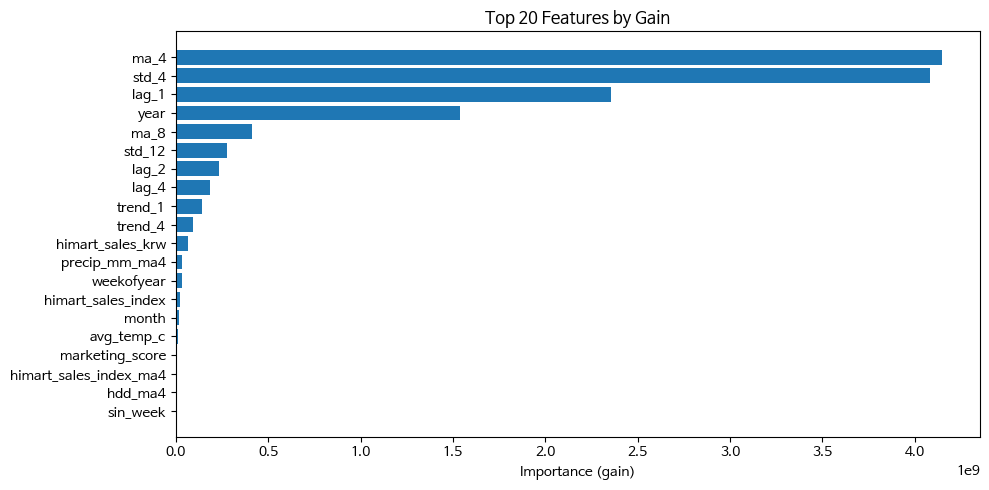

In [120]:
top_n = 20
top_gain = imp_gain_df.head(top_n)

plt.figure(figsize=(10, 5))
plt.barh(top_gain["feature"][::-1], top_gain["importance_gain"][::-1])
plt.xlabel("Importance (gain)")
plt.title(f"Top {top_n} Features by Gain")
plt.tight_layout()
plt.show()


## test + feature + prediction

In [121]:
test_keys = ["warehouse_id", "store_id", "sku_id", "region", "target_date"]

keys_in_both = [c for c in test_keys if c in test.columns and c in pred_df.columns]
print("merge keys:", keys_in_both)

test_merged = pd.merge(
    test,
    pred_df,
    on=keys_in_both + ["y"],  
    how="inner",
    validate="one_to_one"
)

print("test_merged shape:", test_merged.shape)
test_merged[["target_date", "sku_id", "y", "y_pred"]].head(5)


merge keys: ['warehouse_id', 'store_id', 'sku_id', 'region', 'target_date']
test_merged shape: (33800, 49)


,target_date,sku_id,y,y_pred
0,2031-01-06,AC-CAR-16P-2024,2528.0,2518
1,2031-01-13,AC-CAR-16P-2024,3256.0,3229
2,2031-01-20,AC-CAR-16P-2024,3097.0,3062
3,2031-01-27,AC-CAR-16P-2024,2945.0,2914
4,2031-02-03,AC-CAR-16P-2024,3203.0,3183


에러 컬럼 추가

In [122]:
test_merged["error"]      = test_merged["y_pred"] - test_merged["y"]
test_merged["abs_error"]  = test_merged["error"].abs()
test_merged["abs_pct_err"]= test_merged["abs_error"] / test_merged["y"].replace(0, 1)

test_merged[["y", "y_pred", "error", "abs_error"]].head(5)


,y,y_pred,error,abs_error
0,2528.0,2518,-10.0,10.0
1,3256.0,3229,-27.0,27.0
2,3097.0,3062,-35.0,35.0
3,2945.0,2914,-31.0,31.0
4,3203.0,3183,-20.0,20.0


## 실제/예측 시계열(총 수요) 비교

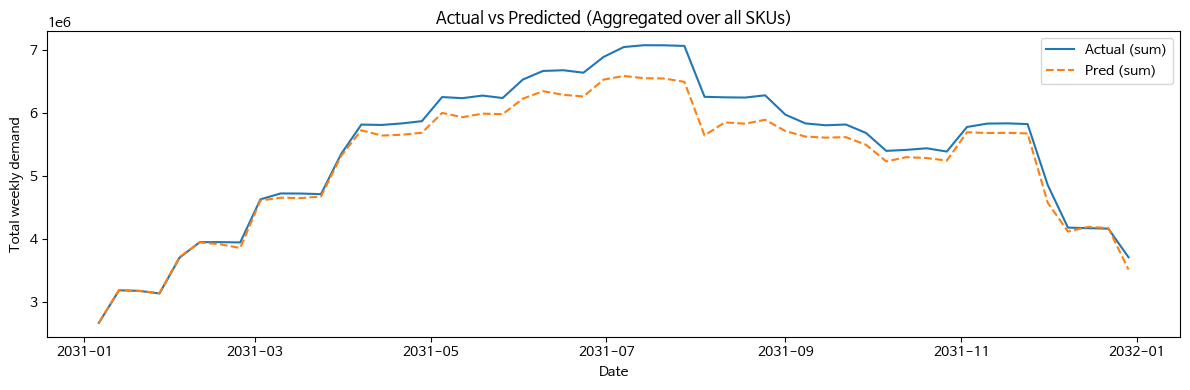

,target_date,y,y_pred
0,2031-01-06,2661752.0,2662355
1,2031-01-13,3178377.0,3184599
2,2031-01-20,3169198.0,3168354
3,2031-01-27,3127992.0,3134024
4,2031-02-03,3697649.0,3708885


In [123]:
ts = (
    test_merged
    .groupby("target_date", as_index=False)[["y", "y_pred"]]
    .sum()
    .sort_values("target_date")
)

plt.figure(figsize=(12, 4))
plt.plot(ts["target_date"], ts["y"], label="Actual (sum)")
plt.plot(ts["target_date"], ts["y_pred"], label="Pred (sum)", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Total weekly demand")
plt.title("Actual vs Predicted (Aggregated over all SKUs)")
plt.legend()
plt.tight_layout()
plt.show()

ts.head()



전반적인 트렌드와 시즌 패턴은 잘 따라감.  
몇몇 급락/급등 지점에서만 차이가 커짐 -> 이벤트성 요인.

## 카테고리 기준 에러 분석

In [124]:
def agg_metrics(df):
    y = df["y"].values
    p = df["y_pred"].values
    return pd.Series({
        "cnt": len(df),
        "mae":  mean_absolute_error(y, p),
        "mape": mape(y, p),
        "smape": smape(y, p),
        "avg_actual": df["y"].mean()
    })

by_cat = (
    test_merged
    .groupby("cat_low")
    .apply(agg_metrics)
    .sort_values("mae", ascending=False)
)

by_cat.head(20)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_32668\2673397132.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_metrics)


,cnt,mae,mape,smape,avg_actual
cat_low,,,,,
믹서기,1040.0,2104.477885,640.299300,27.161052,8332.588462
전자레인지,2080.0,862.017788,5.541345,6.309157,8332.573558
건조기,2080.0,716.352404,4.823640,5.404197,8332.587981
세탁기,2080.0,714.378846,4.738711,5.363979,8332.591827
공기청정기,2080.0,702.638942,4.909200,5.516975,8332.591346
냉장고,2080.0,654.514904,4.641405,5.134228,8332.587981
에어컨,2080.0,635.506731,4.441391,4.976043,8332.590385
tv,2080.0,535.854327,3.884692,4.255537,8332.589904
오븐,1560.0,485.421154,3.656587,3.943175,8332.596795


##  MAE 기준 상위 10개 카테고리 bar plot

In [125]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matyplotlib -rf

Sudo媛� �씠 而댄벂�꽣�뿉�꽌 �궗�슜�븯吏� �븡�룄濡� �꽕�젙�릺�뼱 �엳�뒿�땲�떎. �궗�슜�븯�룄濡� �꽕�젙�븯�젮硫� �쑝濡� �씠�룞�븯�꽭�슂. ]8;;ms-settings:developers\Developer Settings page]8;;\ �꽕�젙 �빋�쓽
Sudo媛� �씠 而댄벂�꽣�뿉�꽌 �궗�슜�븯吏� �븡�룄濡� �꽕�젙�릺�뼱 �엳�뒿�땲�떎. �궗�슜�븯�룄濡� �꽕�젙�븯�젮硫� �쑝濡� �씠�룞�븯�꽭�슂. ]8;;ms-settings:developers\Developer Settings page]8;;\ �꽕�젙 �빋�쓽
'rm'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [126]:
plt.rc('font', family='NanumBarunGothic')

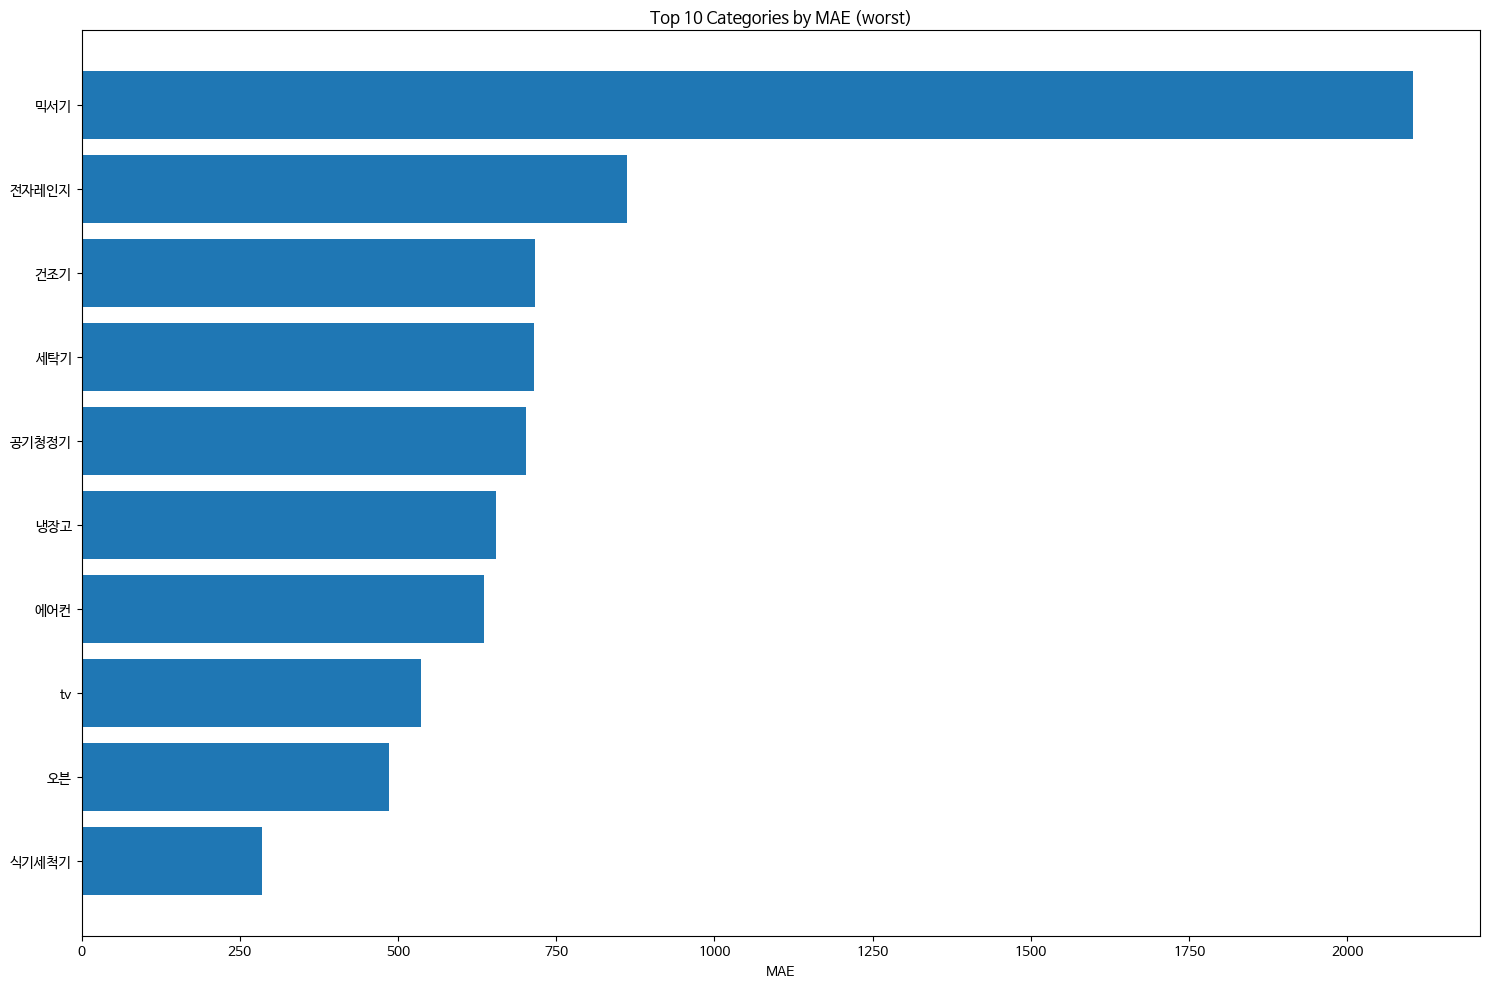

In [127]:
top_n = 10
top_cat = by_cat.head(top_n).reset_index()

plt.figure(figsize=(15, 10))
plt.barh(top_cat["cat_low"][::-1], top_cat["mae"][::-1])
plt.xlabel("MAE")
plt.title(f"Top {top_n} Categories by MAE (worst)")
plt.tight_layout()
plt.show()

## 시간(weekofyear) 기준 에러 분석

In [128]:
tmp = test_merged.copy()
tmp["weekofyear"] = tmp["target_date"].dt.isocalendar().week.astype(int)

by_week = (
    tmp.groupby("weekofyear")
       .apply(lambda df: pd.Series({
           "cnt": len(df),
           "mae": mean_absolute_error(df["y"], df["y_pred"]),
           "mape": mape(df["y"].values, df["y_pred"].values),
           "smape": smape(df["y"].values, df["y_pred"].values),
       }))
       .reset_index()
)

by_week.head()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_32668\588774154.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: pd.Series({


,weekofyear,cnt,mae,mape,smape
0,1,650.0,415.590769,9.409142,6.954038
1,2,650.0,52.620000,1.085576,1.095616
2,3,650.0,63.187692,1.066025,1.062669
3,4,650.0,64.612308,1.069685,1.065470
4,5,650.0,70.455385,1.149477,1.151577


## weekofyear vs MAE 라인 플롯

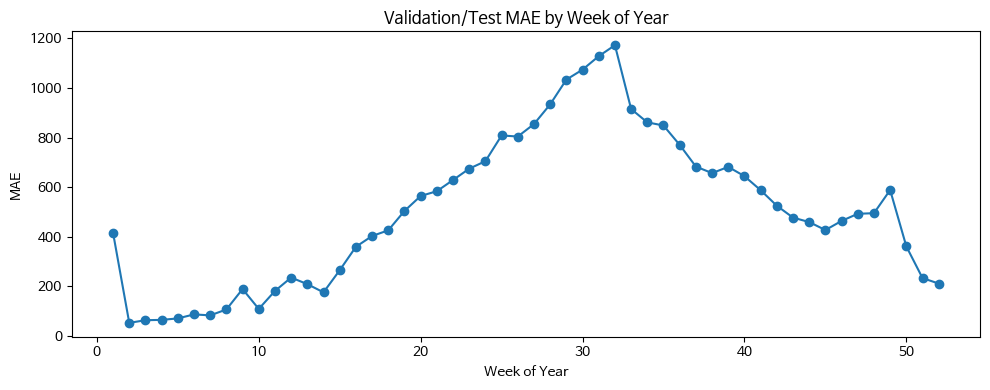

In [129]:
plt.figure(figsize=(10, 4))
plt.plot(by_week["weekofyear"], by_week["mae"], marker="o")
plt.xlabel("Week of Year")
plt.ylabel("MAE")
plt.title("Validation/Test MAE by Week of Year")
plt.tight_layout()
plt.show()


그래프에서 초반 몇 주 MAE가 확 튀어 있음.  
->   설/명절/특정 프로모션 시즌일 가능성이 큼 - 극단 이벤트에서 모델이 상대적으로 약함.

## 중요한 피처 vs 오차 관계

Top feature by gain: ma_4


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_32668\1244682197.py:9: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


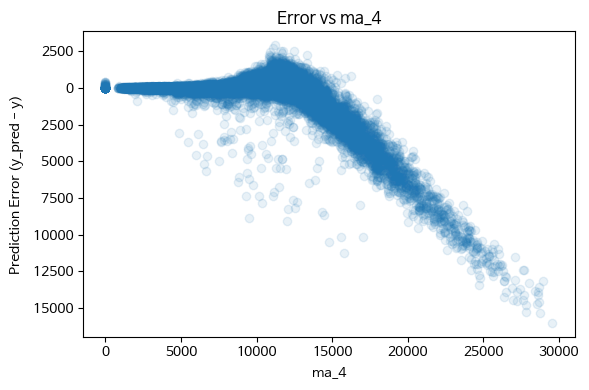

In [130]:
top_feature = imp_gain_df.loc[0, "feature"]
print("Top feature by gain:", top_feature)

plt.figure(figsize=(6, 4))
plt.scatter(test_merged[top_feature], test_merged["error"], alpha=0.1)
plt.xlabel(top_feature)
plt.ylabel("Prediction Error (y_pred - y)")
plt.title(f"Error vs {top_feature}")
plt.tight_layout()
plt.show()


# 가중치  
직접 계산 X    
-> LightGBM이 학습하면서 자동으로 계산한 feature importance    
구한 방식 :   
1. split count: 각 피처가 트리에서 분기 기준으로 사용된 횟수.  
2. gain: 그 피처가 분기될 때마다 손실(에러)을 얼마나 줄였는지 합친 값.  

lag_1이 gain 기준으로 압도적 1등   
-> 이 피처로 분기했을 때 손실을 줄이는 데 제일 많이 기여했다는 의미  
미리 가중치를 튜닝할 필요 X  